In [430]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.0})

import os
import re
import pandas as pd
import numpy as np
import shutil
import subprocess
import multiprocessing
import re
import cantera as ct

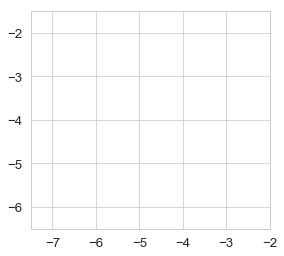

array([[[-7.5   , -7.5   , -7.5   , -7.5   , -7.5   , -7.5   , -7.5   ,
         -7.5   , -7.5   ],
        [-6.8125, -6.8125, -6.8125, -6.8125, -6.8125, -6.8125, -6.8125,
         -6.8125, -6.8125],
        [-6.125 , -6.125 , -6.125 , -6.125 , -6.125 , -6.125 , -6.125 ,
         -6.125 , -6.125 ],
        [-5.4375, -5.4375, -5.4375, -5.4375, -5.4375, -5.4375, -5.4375,
         -5.4375, -5.4375],
        [-4.75  , -4.75  , -4.75  , -4.75  , -4.75  , -4.75  , -4.75  ,
         -4.75  , -4.75  ],
        [-4.0625, -4.0625, -4.0625, -4.0625, -4.0625, -4.0625, -4.0625,
         -4.0625, -4.0625],
        [-3.375 , -3.375 , -3.375 , -3.375 , -3.375 , -3.375 , -3.375 ,
         -3.375 , -3.375 ],
        [-2.6875, -2.6875, -2.6875, -2.6875, -2.6875, -2.6875, -2.6875,
         -2.6875, -2.6875],
        [-2.    , -2.    , -2.    , -2.    , -2.    , -2.    , -2.    ,
         -2.    , -2.    ]],

       [[-6.5   , -5.875 , -5.25  , -4.625 , -4.    , -3.375 , -2.75  ,
         -2.125 , -1.5   ]

In [3]:
carbon_range = (-7.5, -2)
oxygen_range = (-6.5, -1.5)
grid_size = 9
mesh  = np.mgrid[carbon_range[0]:carbon_range[1]:grid_size*1j, 
                 oxygen_range[0]:oxygen_range[1]:grid_size*1j]

with sns.axes_style("whitegrid"):
    plt.axis('square')
    plt.xlim(carbon_range)
    plt.ylim(oxygen_range)
plt.show()
    
mesh

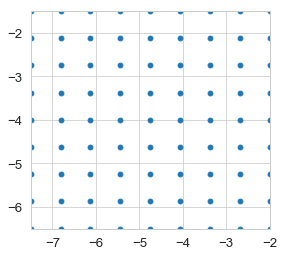

In [4]:
experiments = mesh.reshape((2,-1)).T

with sns.axes_style("whitegrid"):
    plt.axis('square')
    plt.xlim(carbon_range)
    plt.ylim(oxygen_range)
    plt.plot(*experiments.T, marker='o', linestyle='none')

In [441]:
extent = carbon_range + oxygen_range

# Because the center of a corner pixel is in fact the corner of the grid# Becaus 
# we want to stretch the image a little
c_step = mesh[0,1,0]-mesh[0,0,0]
o_step = mesh[1,0,1]-mesh[1,0,0]
carbon_range2 = (carbon_range[0]-c_step/2, carbon_range[1]+c_step/2)
oxygen_range2 = (oxygen_range[0]-c_step/2, oxygen_range[1]+c_step/2)
extent2 = carbon_range2 + oxygen_range2

In [442]:
def calculate(data):
    ratio = data[1]
    ch4_in = data[2]
    ch4_out = data[3]
    co_out = data[4]
    h2_out = data[5]
    h2o_out = data[6]
    co2_out = data[7]
    exit_T = data[8]
    max_T = data[9]
    dist_Tmax = data[10]
    
    ch4_depletion = ch4_in - ch4_out
    if ch4_depletion <= 0:
        ch4_depletion = 1e-15
    ch4_conv = ch4_depletion / ch4_in
    h2_sel = h2_out / (ch4_depletion * 2)
    h2_yield = h2_out / ( ch4_in * 2)
    co_sel = co_out / ch4_depletion
    co_yield = co_out / ch4_in
    syngas_sel = co_sel + h2_sel
    syngas_yield = syngas_sel * ch4_conv
    co2_sel = co2_out / ch4_depletion
    h2o_sel = h2o_out / (2 * ch4_depletion)
    fullox_sel = h2o_sel + co2_sel
    fullox_yield = fullox_sel * ch4_conv
    
    return syngas_sel, syngas_yield, co_sel, co_yield, h2_sel, h2_yield, ch4_conv, fullox_sel, fullox_yield, exit_T, max_T, dist_Tmax
    
def import_data(ratio, file_location=False):
    """
    This imports dict_conversions_celectivities from the original simulation
    """
    if file_location is False:
        data = pd.read_csv('./dict_conversions_selectivities.csv')
    else:
        data = pd.read_csv('./linearscaling/' + file_location + '/dict_conversions_selectivities.csv')
    
    data = data.get_values()
    for x in range(len(data)):
        r = round(data[x][1],1)
        if r == ratio:
            return calculate(data[x])


# For close packed surfaces from
# Abild-Pedersen, F.; Greeley, J.; Studt, F.; Rossmeisl, J.; Munter, T. R.; Moses, P. G.; Skúlason, E.; Bligaard, T.; Norskov, J. K. Scaling Properties of Adsorption Energies for Hydrogen-Containing Molecules on Transition-Metal Surfaces. Phys. Rev. Lett. 2007, 99 (1), 016105 DOI: 10.1103/PhysRevLett.99.016105.
abildpedersen_energies = { # Carbon, then Oxygen
'Ru': ( -6.397727272727272, -5.104763568600047),
'Rh': ( -6.5681818181818175, -4.609771721406942),
'Ni': ( -6.045454545454545, -4.711681807593758),
'Ir': ( -6.613636363636363, -5.94916142557652),
'Pd': ( -6, -3.517877940833916),
'Pt': ( -6.363636363636363, -3.481481481481482),
'Cu': ( -4.159090909090907, -3.85272536687631),
'Ag': ( -2.9545454545454533, -2.9282552993244817),
'Au': ( -3.7499999999999973, -2.302236198462614),
}


def lavaPlot(overall_rate, title, axis=False):
    """
    overall rate data to plot
    title is a string for what definition is used
    to normalize colors across many plots, False doesn't normalize axes 
    """
#     df = pd.DataFrame(index=np.unique(o_s), columns=np.unique(c_s))
#     print df
#     for c, o, t in zip(c_s, o_s, overall_rate):
#         df[c][o] = t
#     a = []
#     for i in df.values: 
#         a = a + list(i)

    overall_rate = np.array(overall_rate)
#     rates = 1./np.array(a)
    rates = overall_rate

    rates_grid = np.reshape(rates, (grid_size,grid_size))
    for i in range(0,8):  # transpose by second diagnol
        for j in range(0, 8 - i):
            rates_grid[i][j], rates_grid[8 - j][8 - i] = rates_grid[8 - j][8 - i], rates_grid[i][j]
    if axis is False:  # no normalizing
        plt.imshow(rates_grid, interpolation='spline16', origin='lower', 
                   extent=extent2, aspect='equal', cmap="Spectral_r",)
    else:
        plt.imshow(rates_grid, interpolation='spline16', origin='lower', 
                   extent=extent2, aspect='equal', cmap="Spectral_r", 
                   vmin=axis[0], vmax=axis[1],)
    for metal, coords in abildpedersen_energies.iteritems():
        color = {'Ag':'k','Au':'k','Cu':'k'}.get(metal,'k')
        plt.plot(coords[0], coords[1], 'o'+color)
        plt.text(coords[0], coords[1], metal, color=color)
    plt.xlim(carbon_range)
    plt.ylim(oxygen_range)
    plt.xlabel('$\Delta E^C$ (eV)')
    plt.ylabel('$\Delta E^O$ (eV)')
    plt.title(str(title))
    plt.colorbar()
    out_dir = 'lsr'
    os.path.exists(out_dir) or os.makedirs(out_dir)
    plt.savefig(out_dir + '/' + str(title) +'.png', bbox_inches='tight')
    plt.show()  # comment out to save fig
    plt.clf()

SynGas Selectivity 1.3913555224692635e-11 137.3795948751
SynGas Yield 7.301959703357164e-19 1.4959571543095207
CO Selectivity 1.165515599730815e-26 68.0829012561
CO Yield 3.484852279976194e-33 0.818959937926673
H2 Selectivity 3.3646112563786026e-12 69.29669361899998
H2 Yield 7.261829789029199e-19 0.7059125609087754
CH4 Conversion 9.136080852257513e-15 0.9841785006479921
CO2+H2O Selectivity 1.551686775707685e-11 1.9993558570655767
CO2+H2O Yield 4.1111369468831225e-21 0.5323000617670208
Exit Temperature 699.994447005 1883.05018961
Maximum Temperature 700.0 1932.60356299
Dist to Max Temperature 0.02 70.0


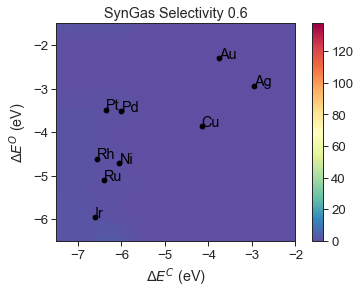

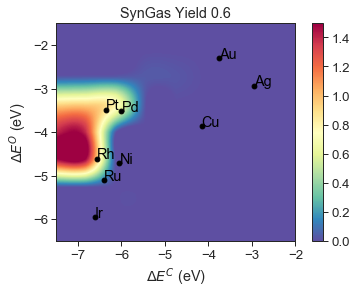

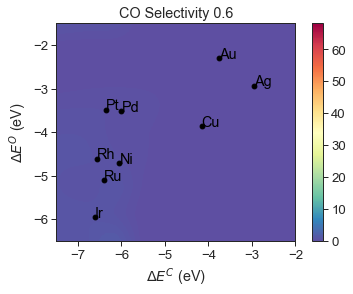

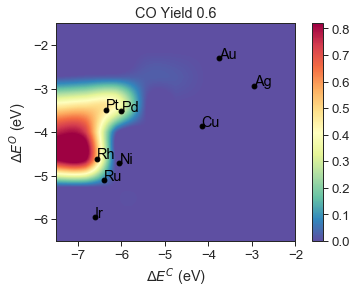

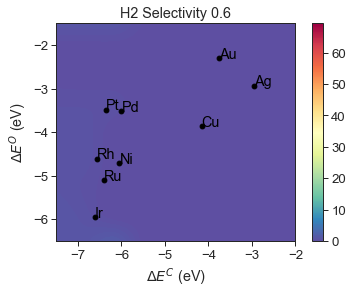

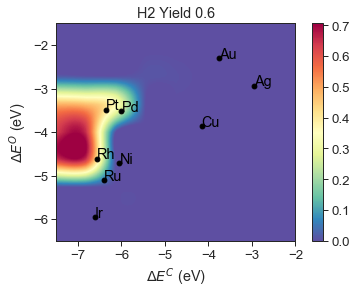

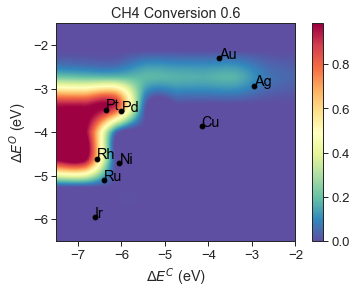

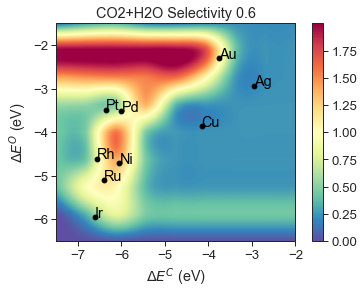

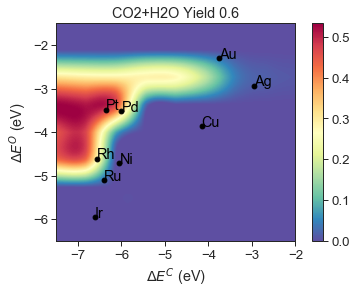

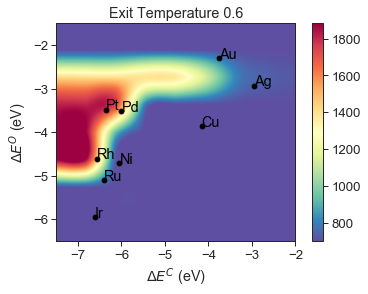

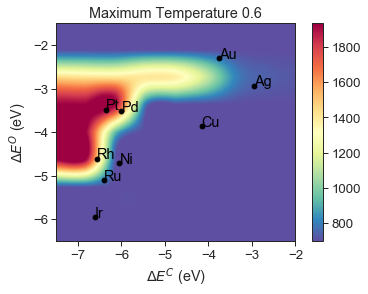

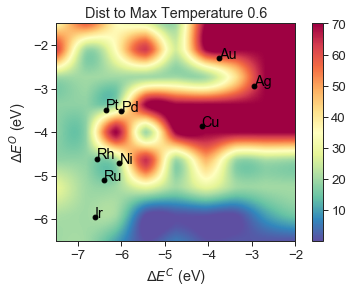

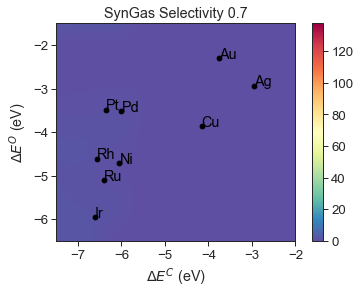

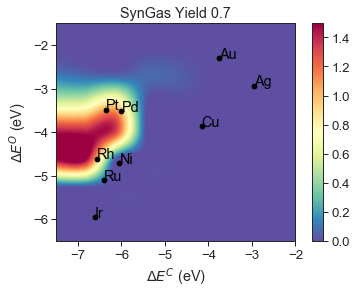

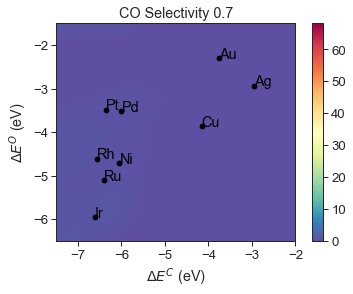

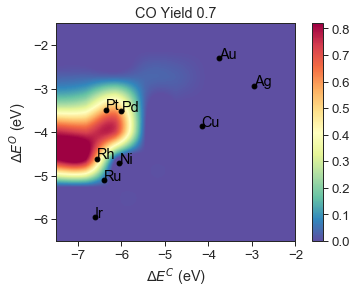

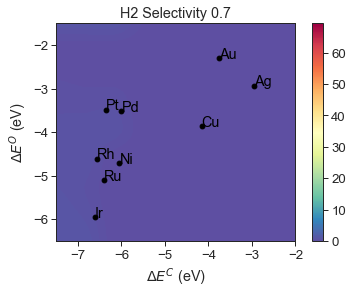

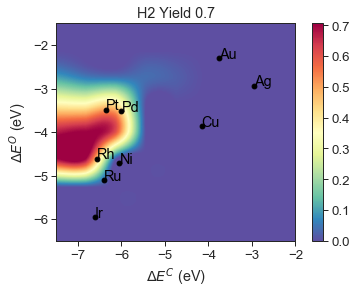

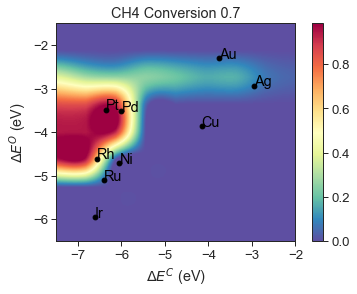

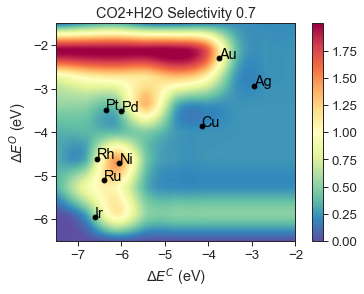

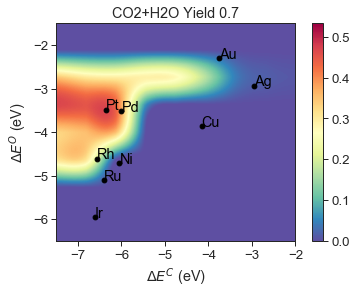

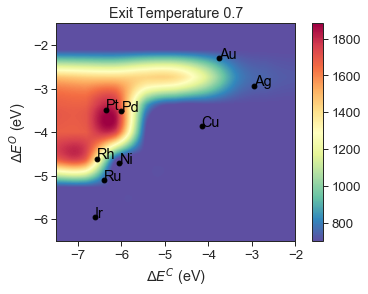

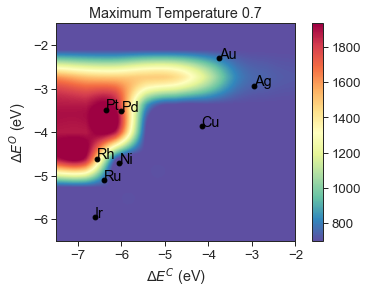

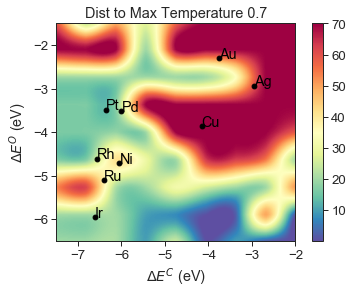

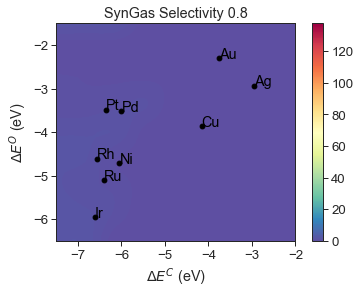

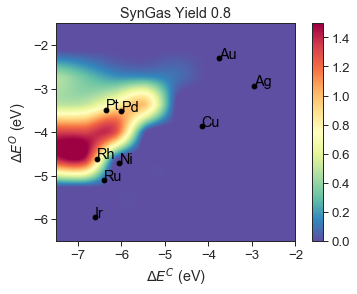

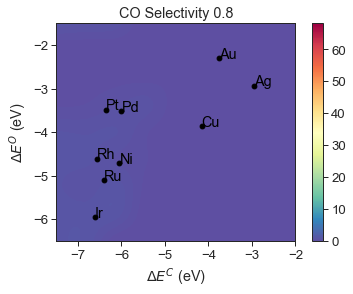

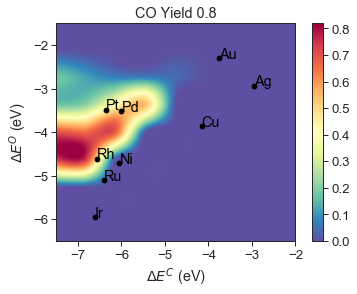

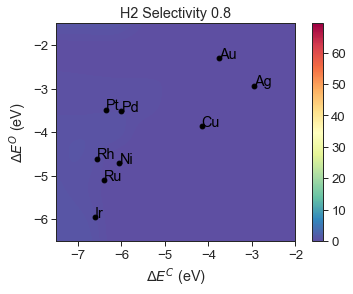

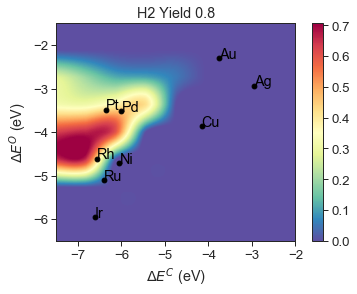

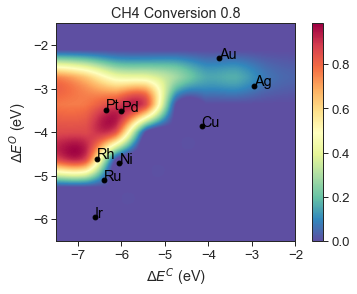

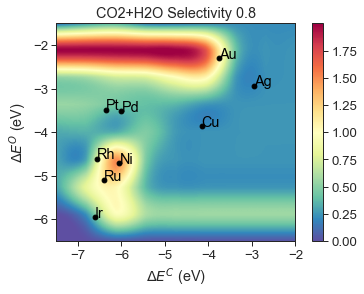

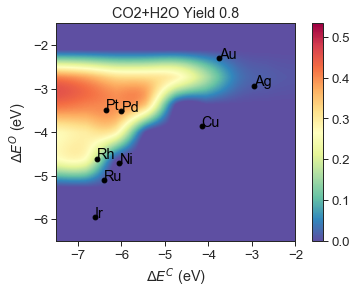

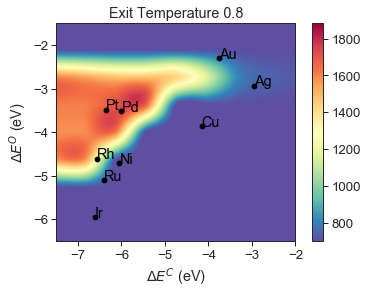

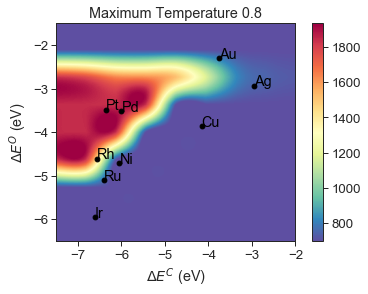

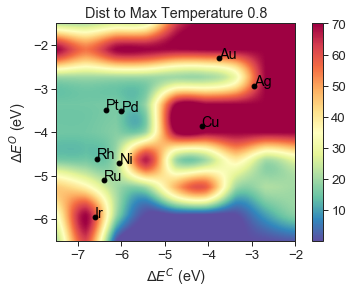

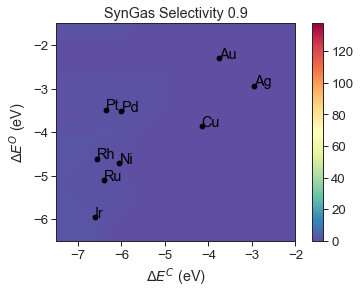

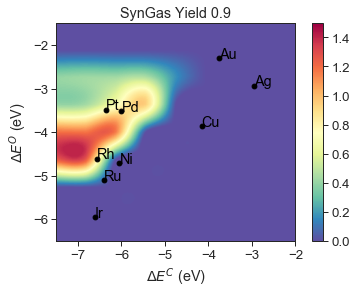

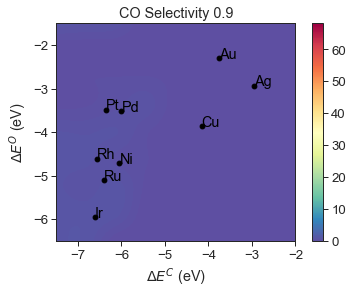

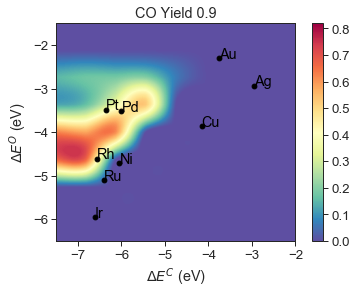

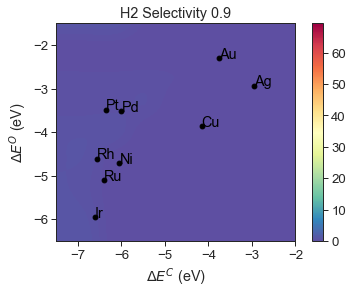

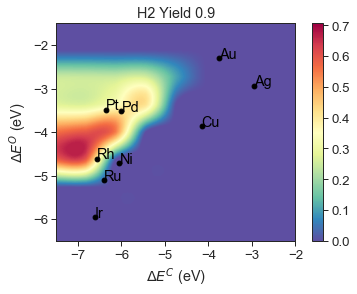

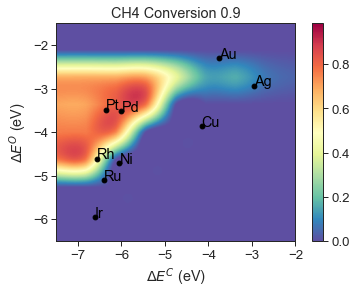

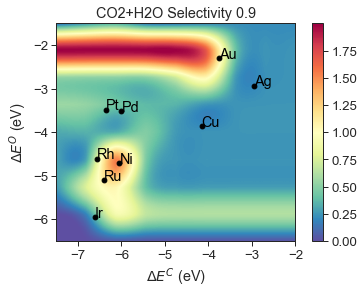

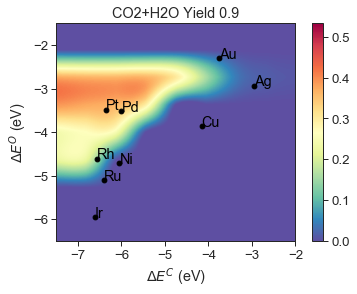

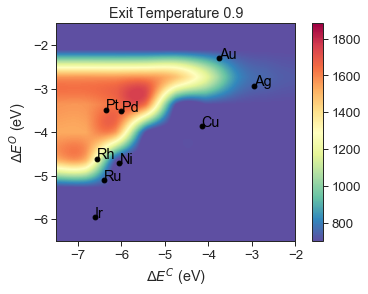

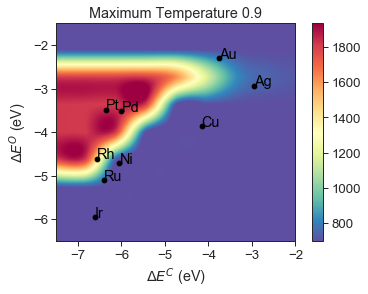

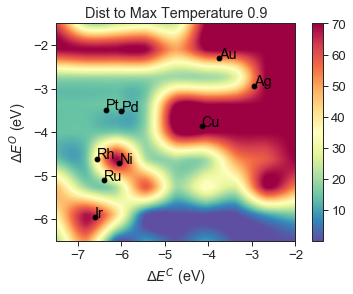

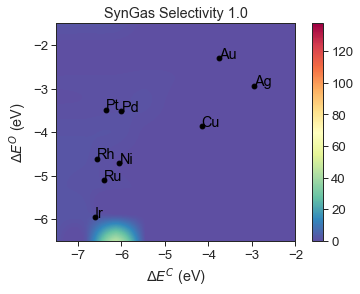

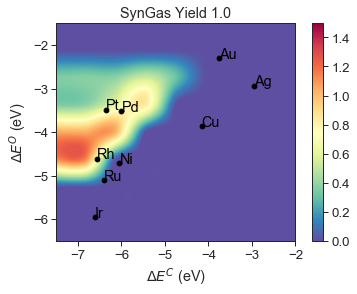

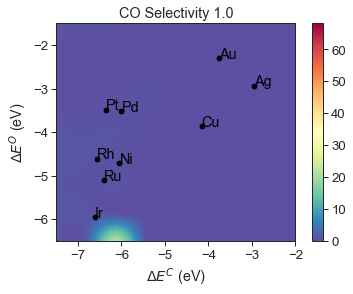

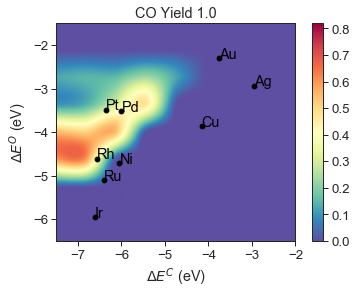

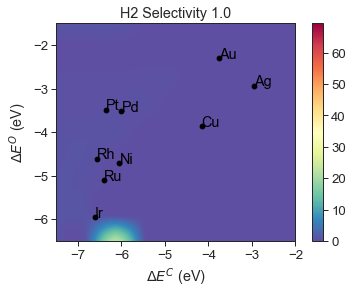

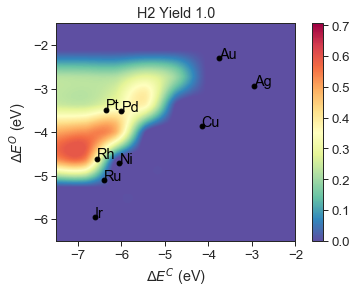

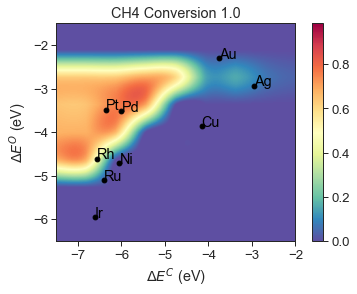

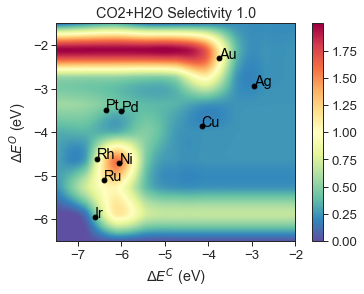

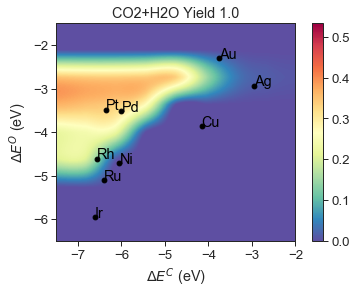

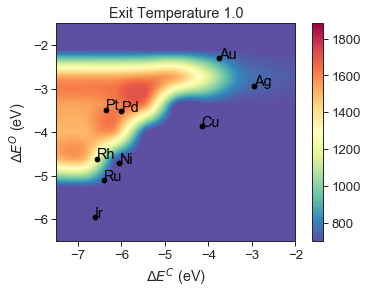

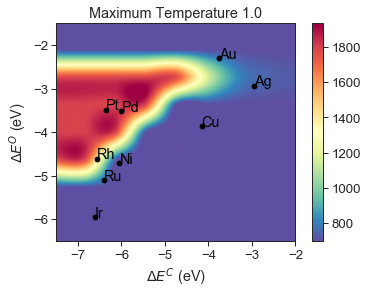

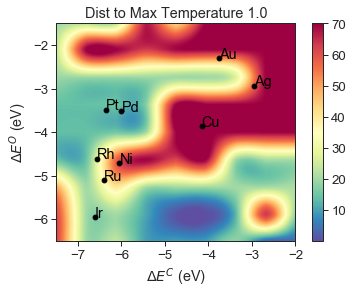

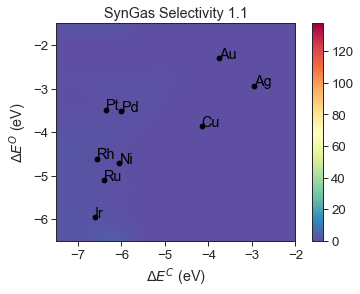

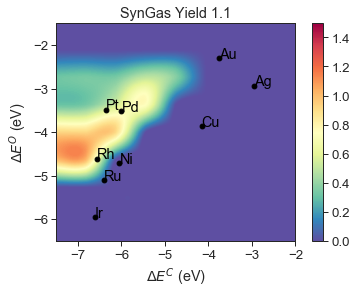

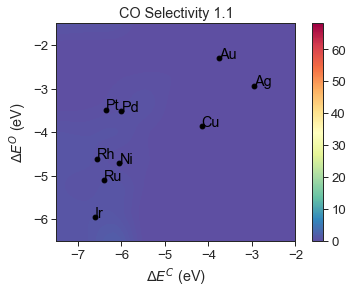

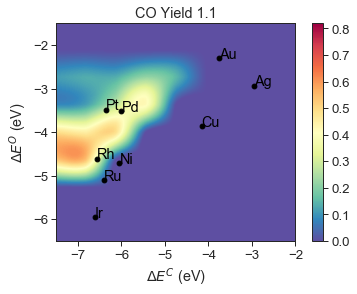

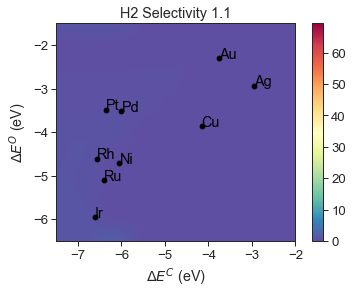

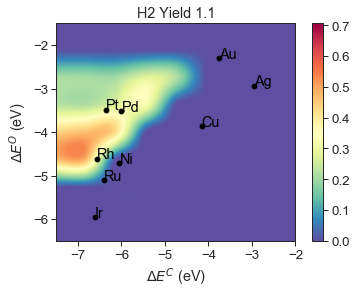

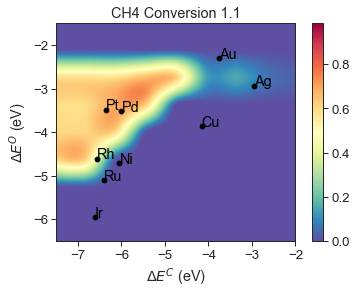

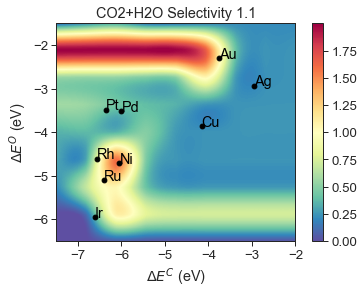

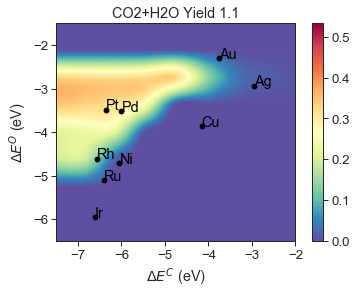

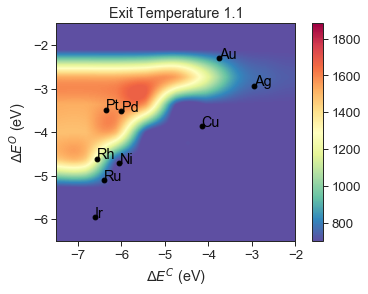

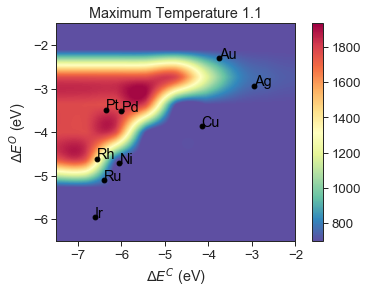

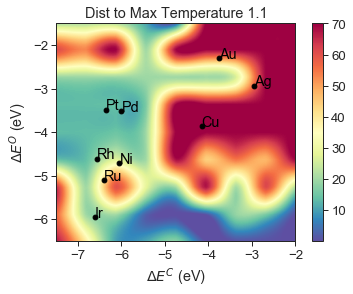

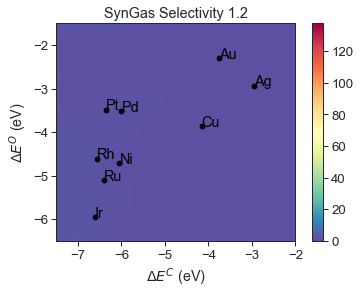

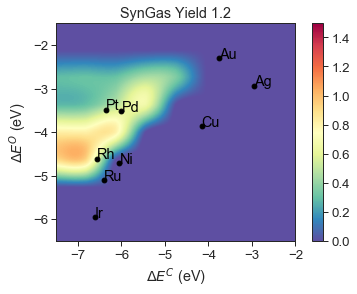

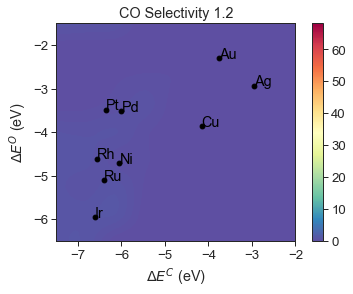

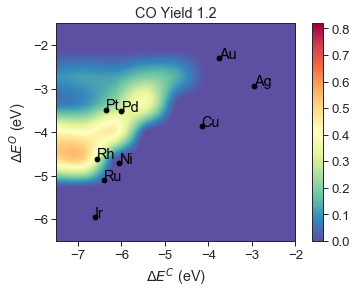

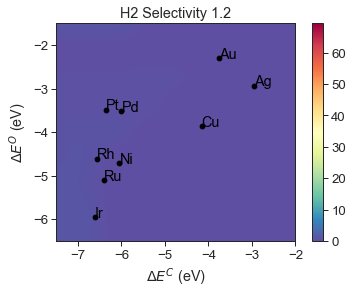

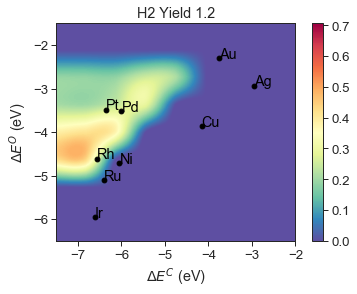

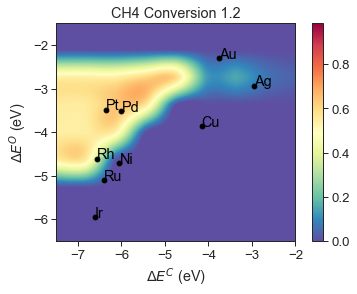

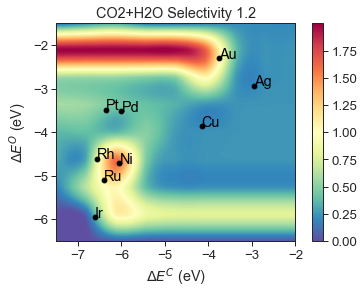

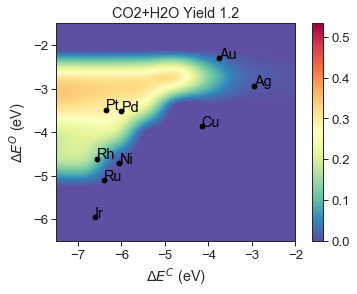

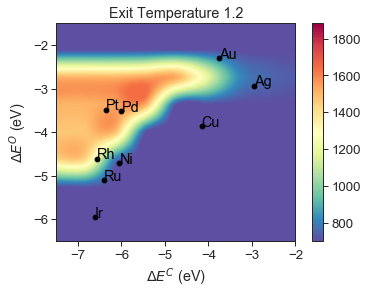

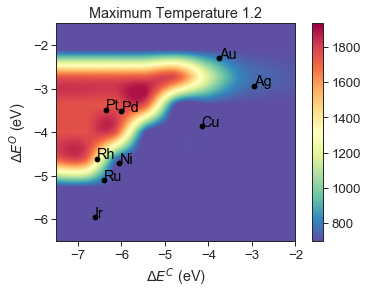

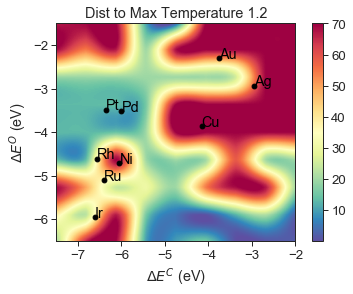

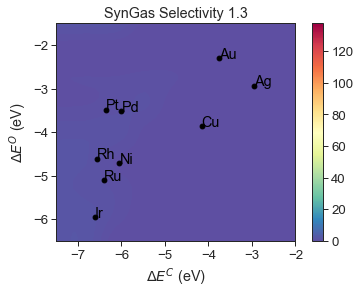

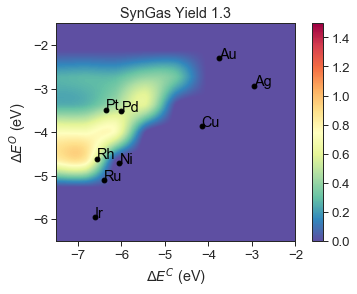

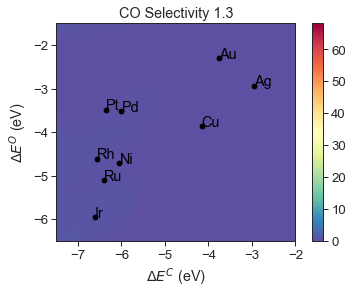

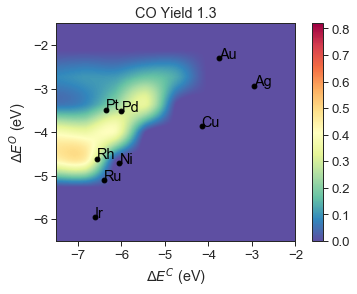

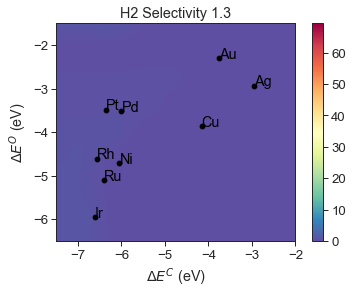

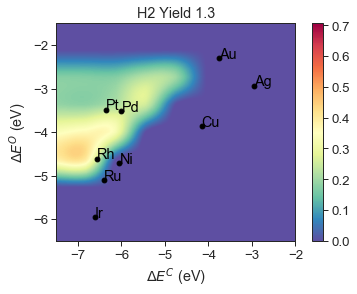

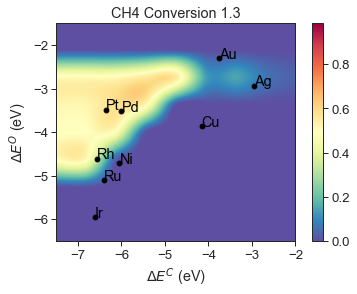

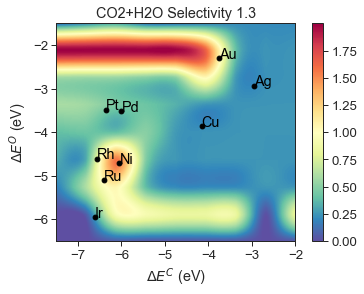

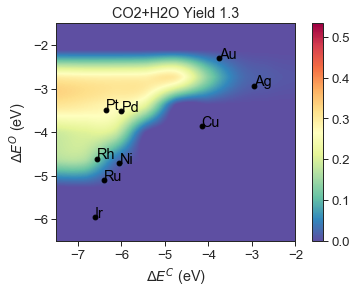

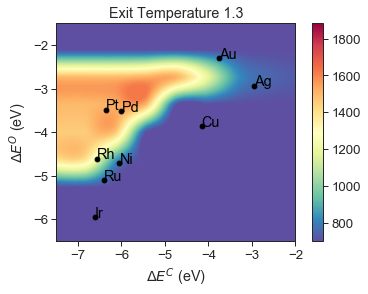

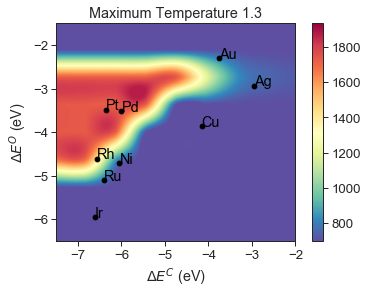

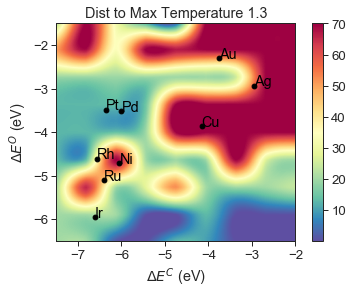

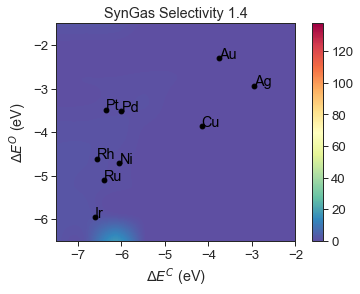

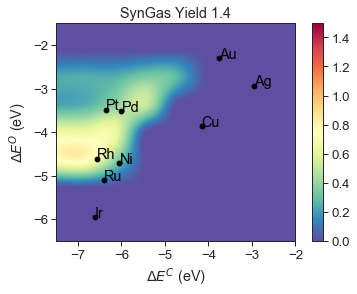

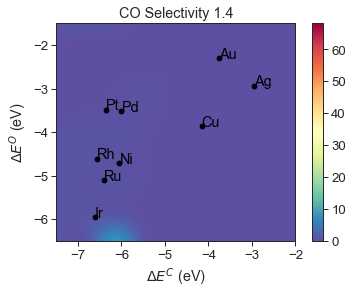

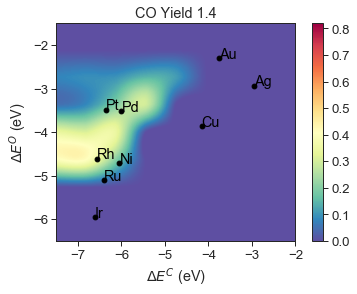

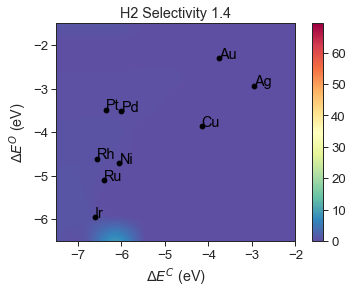

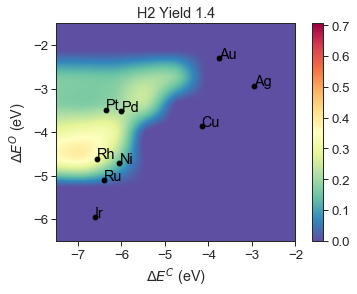

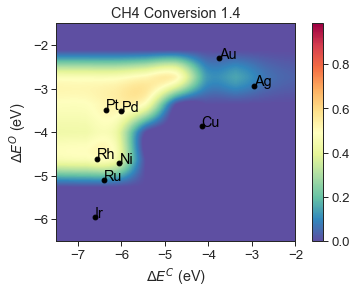

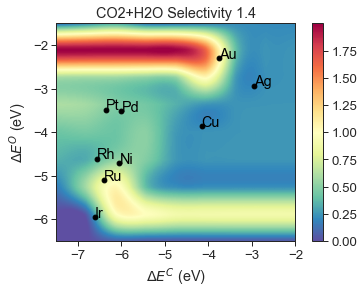

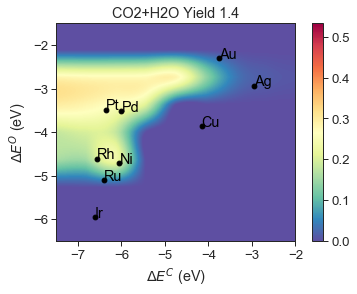

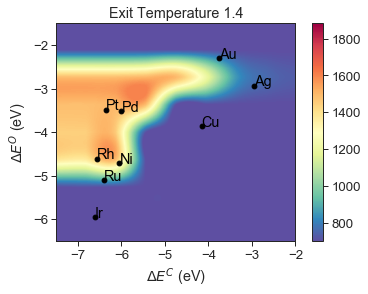

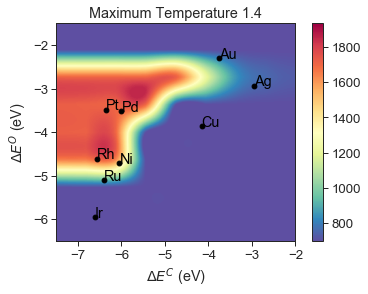

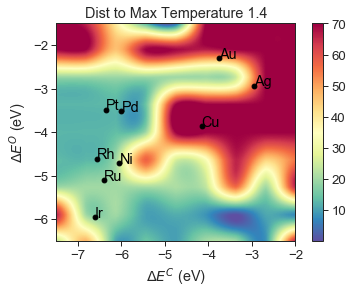

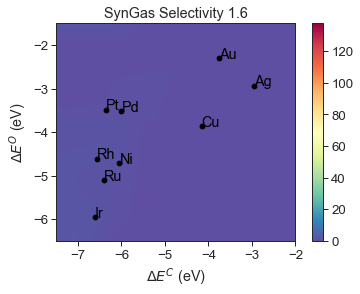

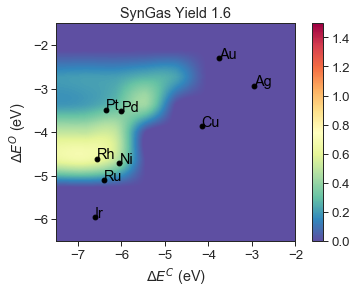

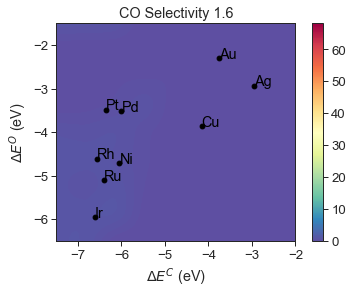

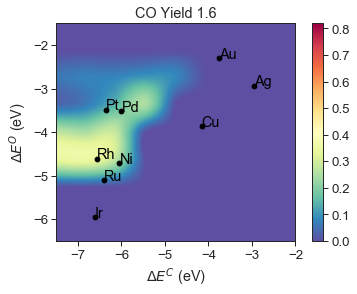

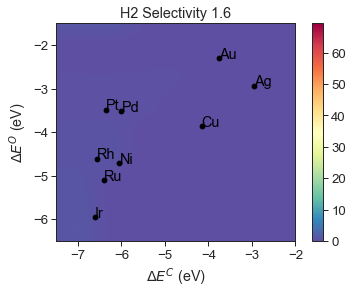

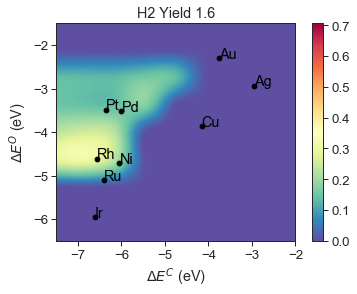

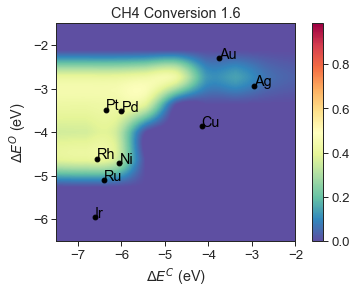

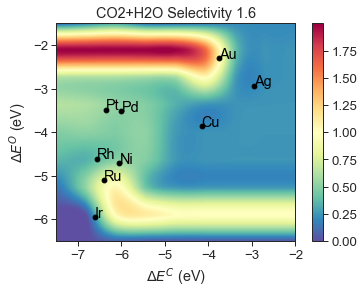

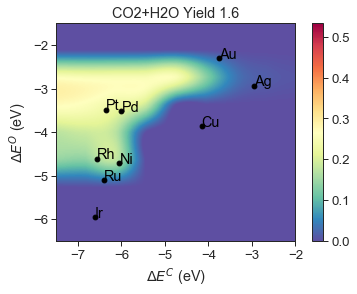

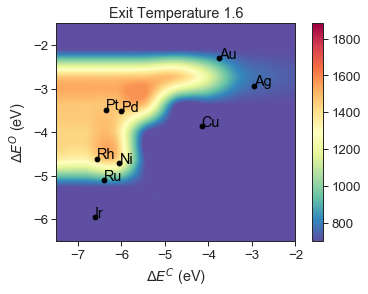

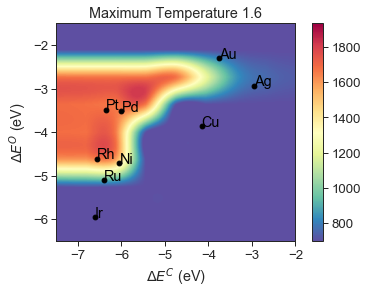

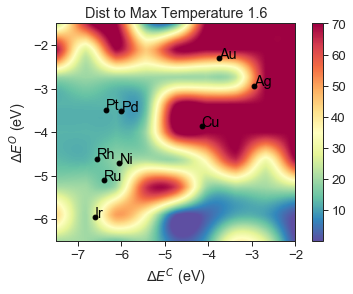

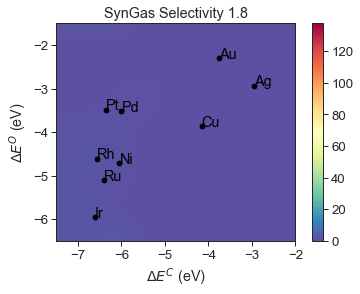

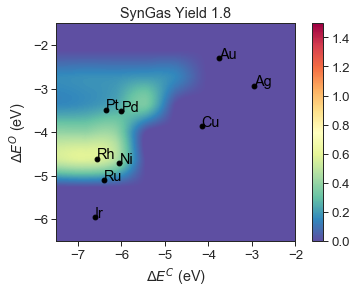

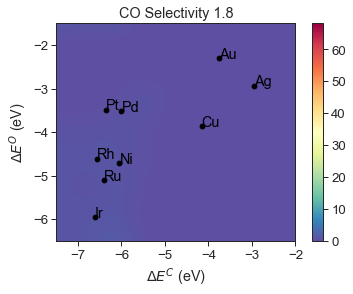

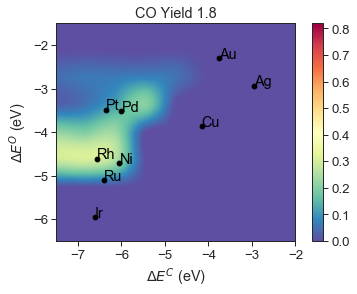

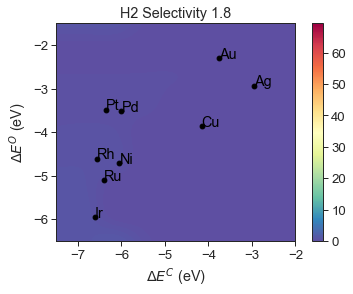

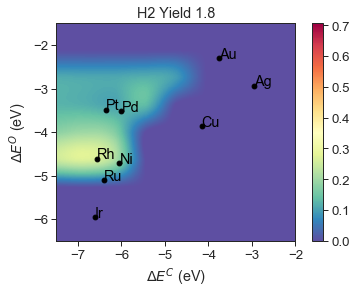

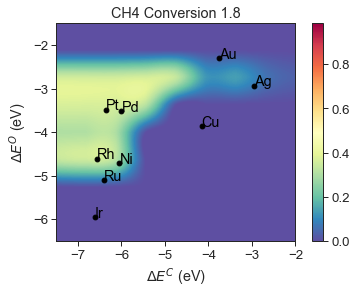

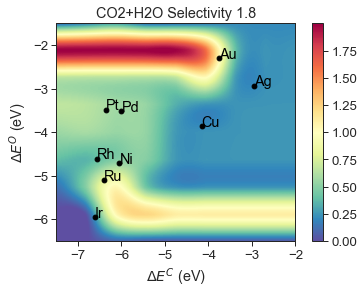

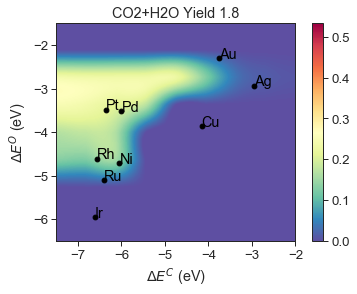

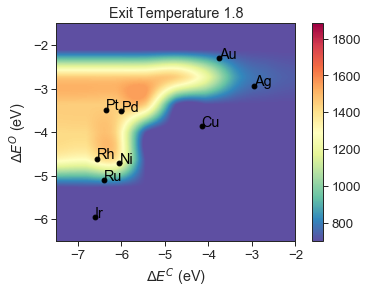

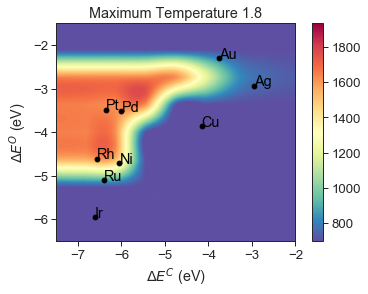

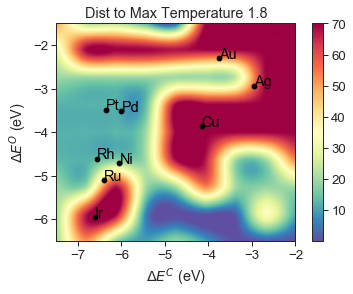

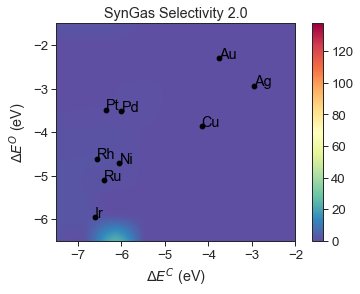

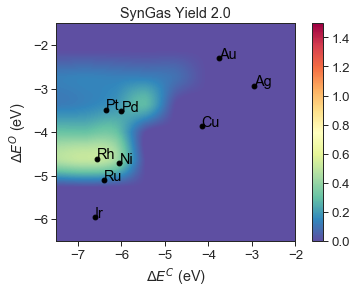

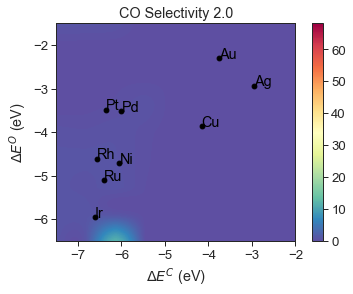

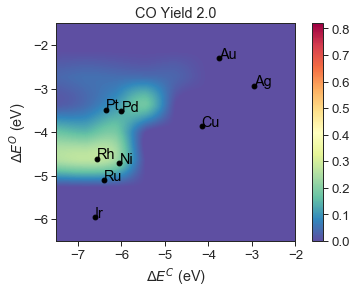

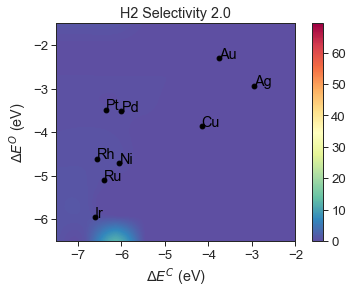

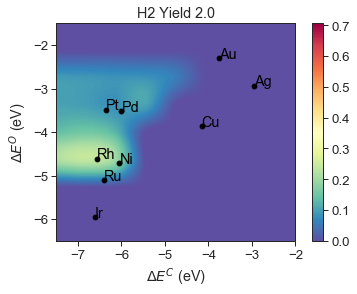

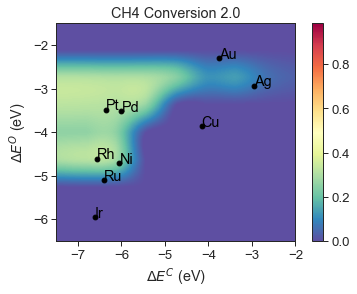

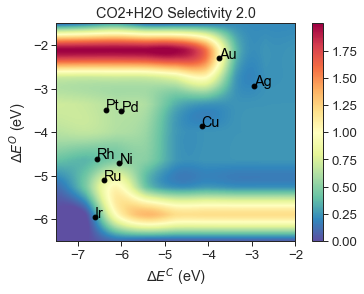

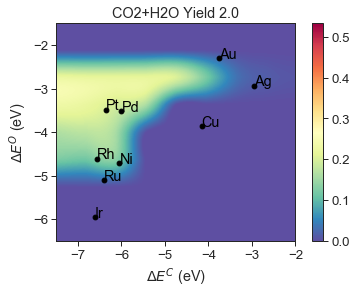

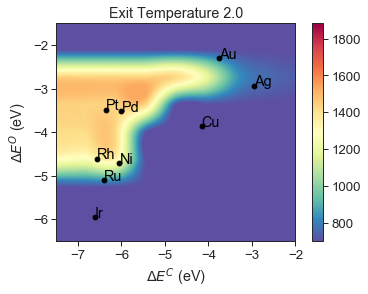

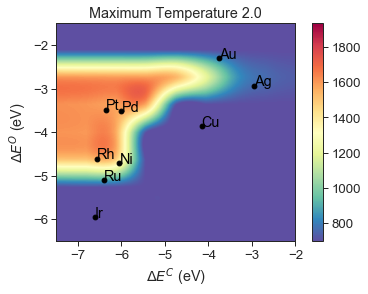

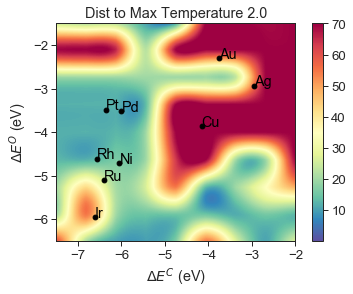

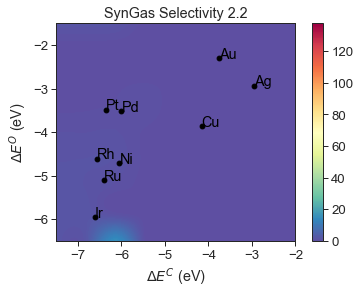

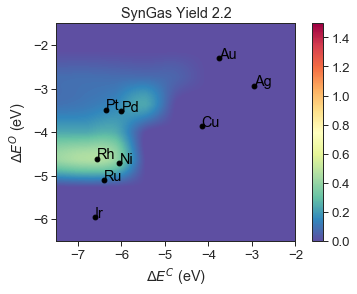

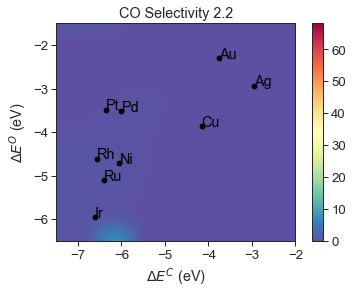

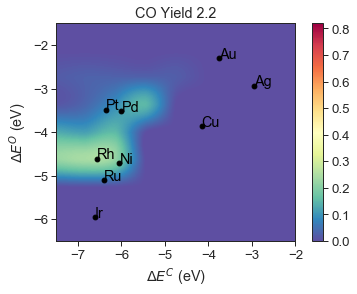

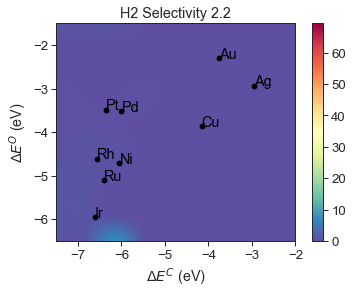

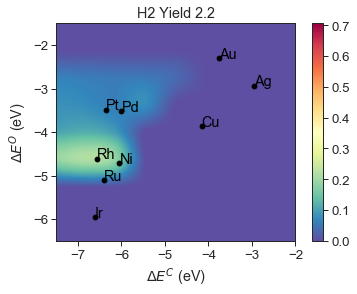

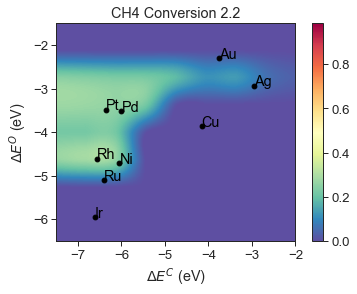

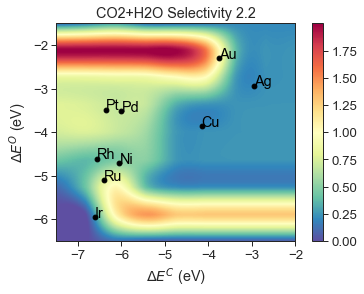

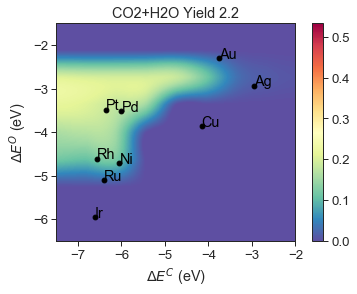

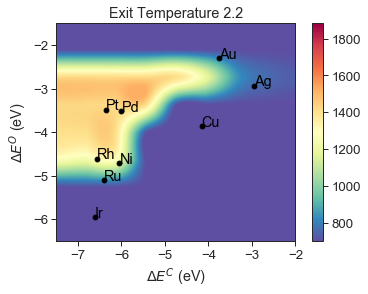

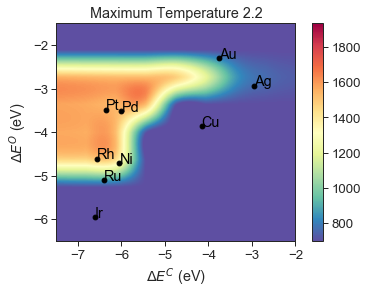

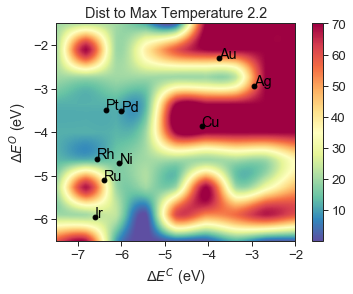

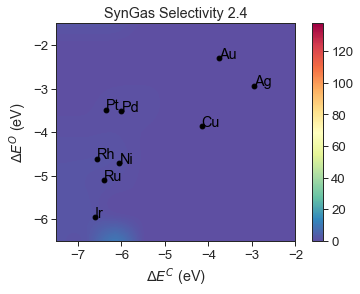

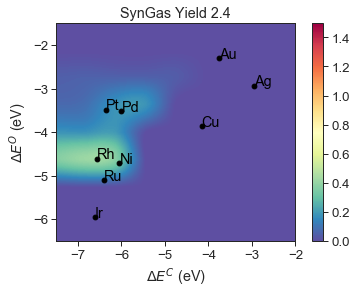

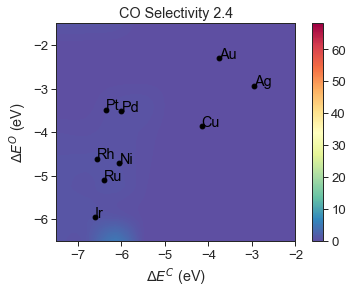

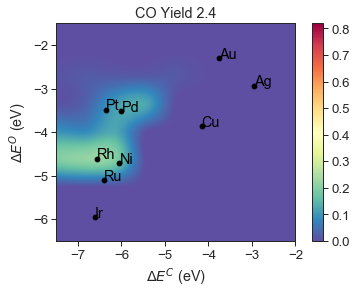

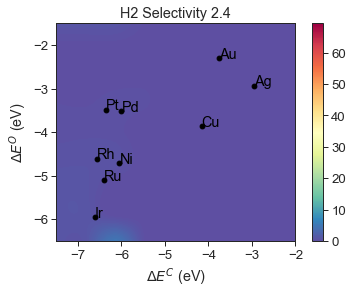

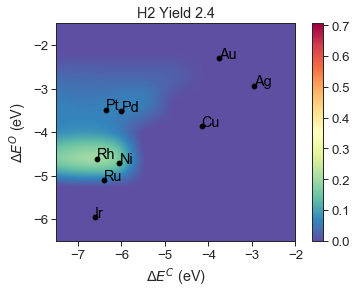

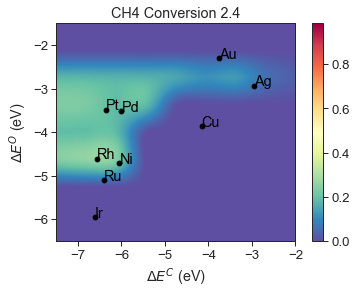

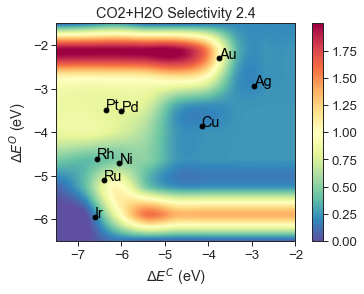

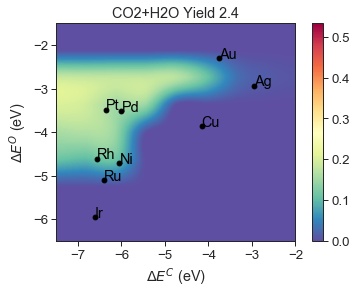

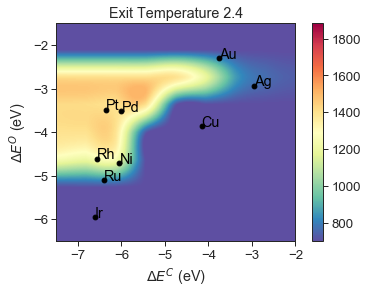

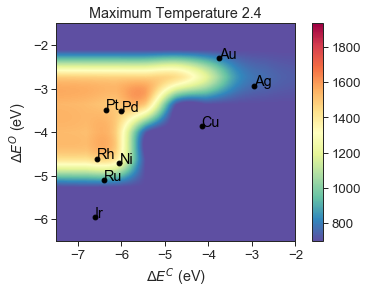

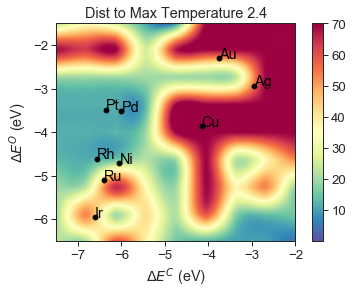

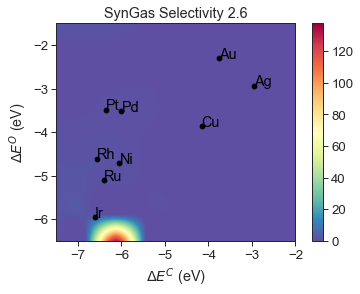

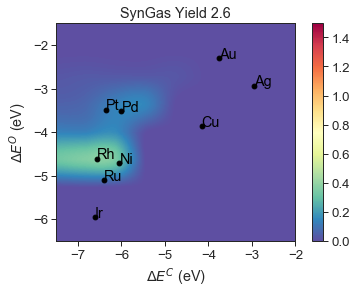

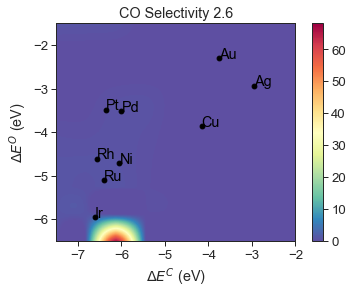

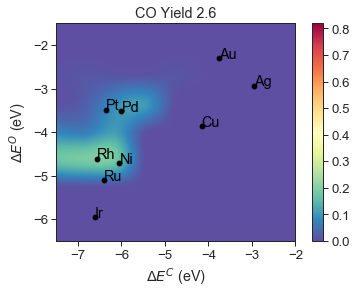

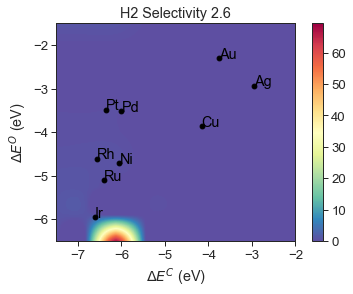

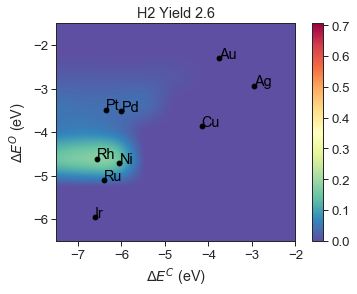

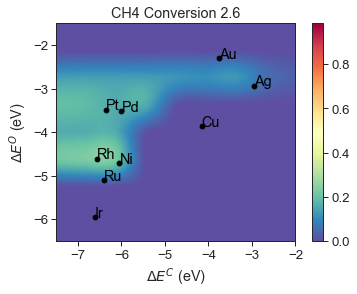

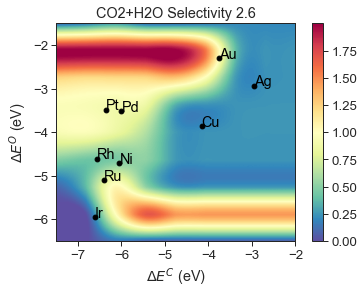

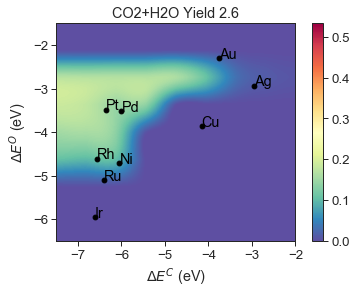

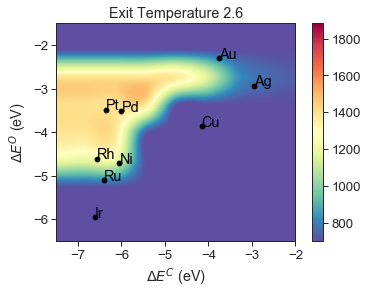

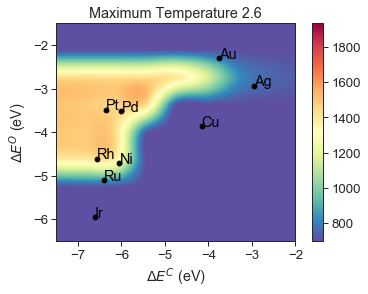

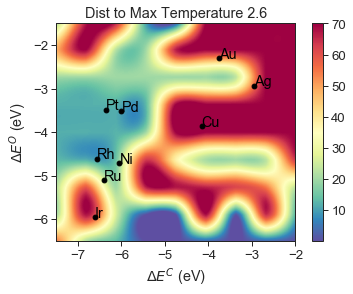

<Figure size 432x288 with 0 Axes>

In [469]:
array = os.listdir('./linearscaling/')
array = sorted(array)

# for plotting
c_s = []
o_s = []
for x in array:
    _, c, o = x.split("-")
    c = c[:-1]
    c = -1 *float(c)
    o = -1* float(o)
    c_s.append(c)
    o_s.append(o)

ratios = [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6]
sens_types = ['SynGas Selectivity', 'SynGas Yield', 'CO Selectivity', 'CO Yield',
              'H2 Selectivity', 'H2 Yield', 'CH4 Conversion', 'CO2+H2O Selectivity',
              'CO2+H2O Yield', 'Exit Temperature', 'Maximum Temperature', 
              'Dist to Max Temperature']
all_data = []
for ratio in ratios:
    ans = []
    for f in array:
        ans.append(import_data(ratio, file_location=f))
    all_data.append(ans)

#     for s in range(len(ans[0])):  # plot each original sens value
#         data_to_plot = []
#         for x in range(len(ans)):
#             data_to_plot.append(ans[x][s])
#         title = str(ratio) + ' ' + sens_types[s]
#         lavaPlot(data_to_plot, title)  # making plots
    
    
# to normalize colors across ratios
spans = []
for m in range(len(all_data[0][0])):  # for each sens definition
    all_sens_data = []
    for x in range(len(all_data)):  # for each ratio
        for y in range(len(all_data[0])):
            # x has len 15 and is each of the ratios
            # y has len 81 and is each of the lsr binding energies
            # the last number is the type of sensitivity definition and is 0-12
            all_sens_data.append(all_data[x][y][m])
    vmax = max(all_sens_data)
    vmin = min(all_sens_data)
    spans.append([vmin, vmax])
    print sens_types[m], vmin, vmax

for z in range(len(all_data)):
    ans = all_data[z]
    for s in range(len(ans[0])):
        data_to_plot = []
        for x in range(len(ans)):
            data_to_plot.append(ans[x][s])
        title = sens_types[s] + ' ' + str(ratios[z])
        lavaPlot(data_to_plot, title, axis=spans[s])  # making plots


In [445]:
def import_sensitivities(ratio, file_location=False, thermo=False):
    """
    Ratio is the C/O starting gas ratio
    file_location is the LSR C and O binding energy, fasle to load the base case
    thermo is either False to load reaction sensitivities or True to load thermo sensitivities
    """
    try:
        # load in the sensitivity csv files
        if file_location is False:
            if thermo is False:
                data = pd.read_csv('./sensitivities/' + str(ratio) + 'RxnSensitivity.csv')
            else:
                data = pd.read_csv('./sensitivities/' + str(ratio) + 'ThermoSensitivity.csv')
        else:
            if thermo is False:
                data = pd.read_csv('./linearscaling/' + file_location + '/sensitivities/' + str(ratio) + 'RxnSensitivity.csv')
            else:
                data = pd.read_csv('./linearscaling/' + file_location + '/sensitivities/' + str(ratio) + 'ThermoSensitivity.csv')
        data = data.get_values()
        data = data.tolist()
        return data
    except:
        if thermo is False:
            print('Cannot find ' + str(ratio) + 'RxnSensitivity.csv for:    ' + file_location)
        else:
            print('Cannot find ' + str(ratio) + 'ThermoSensitivity.csv for: ' + file_location)
        # try loading the reactions from a different ratio to use as placeholders
        try_ratios = [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6]
        for r in try_ratios:
            try:
                if file_location is False:
                    if thermo is False:
                        data = pd.read_csv('./sensitivities/' + str(r) + 'RxnSensitivity.csv')
                    else:
                        data = pd.read_csv('./sensitivities/' + str(r) + 'ThermoSensitivity.csv')
                else:
                    if thermo is False:
                        data = pd.read_csv('./linearscaling/' + file_location + '/sensitivities/' + str(r) + 'RxnSensitivity.csv')
                    else:
                        data = pd.read_csv('./linearscaling/' + file_location + '/sensitivities/' + str(r) + 'ThermoSensitivity.csv')
                data = data.get_values()
                fakedata = data
#                 fakedata = np.zeros_like(data, dtype=float)
                for x in range(len(data)):
                    for y in xrange(2,14):
                        fakedata[x][y] = 0.0
                return fakedata.tolist()
                break
            except:
                continue

In [446]:
allrxndata = []  # where all rxn sens itivities will be stored
allthermodata = []  # where all thermo sensitivities will be stored
for f in array:
    rxndata = []
    thermodata = []
    for ratio in ratios:
        rxndata.append(import_sensitivities(ratio, file_location=f))
        thermodata.append(import_sensitivities(ratio, file_location=f, thermo=True))
    allrxndata.append(rxndata)
    allthermodata.append(thermodata)

Cannot find 0.9RxnSensitivity.csv for:    c-6.125o-1.500
Cannot find 1.4RxnSensitivity.csv for:    c-6.125o-1.500
Cannot find 2.0RxnSensitivity.csv for:    c-6.125o-1.500
Cannot find 2.2RxnSensitivity.csv for:    c-6.125o-1.500
Cannot find 2.4RxnSensitivity.csv for:    c-6.125o-1.500


In [447]:
num_surf_reactions = []
for x in array:
    gas = ct.Solution('./linearscaling/' + x + '/chem_annotated.cti', 'gas')
    surf = ct.Interface('./linearscaling/' + x + '/chem_annotated.cti', 'surface1', [gas])
    num_surf_reactions.append(surf.n_reactions)

# allrxndata[lsr BEs][c/o ratios][surface reactions][1=reaction, 2-14=sensitivities]

Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Selectivity 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Selectivity 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Selectivity 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Selectivity 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Selectivity 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Selectivity 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Selectivity 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Selectivity 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Selectivity 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Selectivity 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Selectivity 0.6
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.77004582758e-06, -2.96072260675e-08, -7.2374615514399994e-06, -0.00130772242047, -0.182055638682, -46.9613259726, 0.04874668135

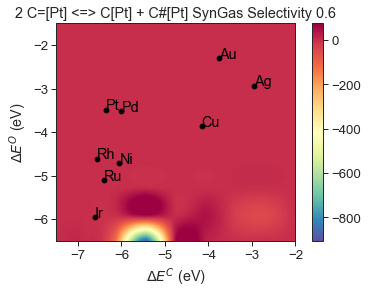

Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Yield 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Yield 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Yield 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Yield 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Yield 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Yield 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Yield 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Yield 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Yield 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Yield 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Yield 0.6
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.78116265432e-06, 1.02242261929e-09, -5.11944325115e-07, -0.00103083478499, -0.0007002581893539999, -4.05131555232e-09, 0.048746681206300005, 3.4910197872600004e-07, 0.000626264786391, 2.0691816

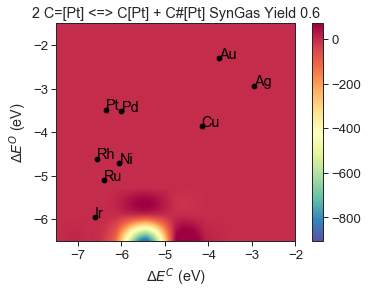

Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Selectivity 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Selectivity 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Selectivity 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Selectivity 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Selectivity 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Selectivity 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Selectivity 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Selectivity 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Selectivity 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Selectivity 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Selectivity 0.6
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.72998741038e-07, 3.0885748965400007e-08, 7.23662163314e-06, 0.000296289950861, 0.18134716684500002, 46.9613291108, -99.7011515126, 1.6340532066100001e-06, 1.06209775615e-07

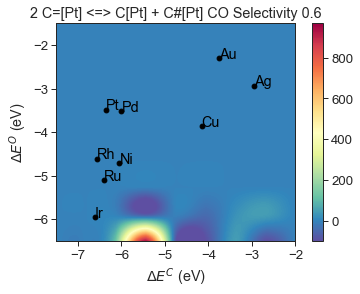

Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Yield 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Yield 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Yield 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Yield 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Yield 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Yield 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Yield 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Yield 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Yield 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Yield 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Yield 0.6
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.84115569505e-07, -2.5609599453e-10, -5.11104402593e-07, -1.94051158599e-05, 6.93113038285e-06, -2.13943832868e-06, 99.7011515126, -7.68406821153e-07, -1.8804745506e-07, 2.4471479906399997e-07, -3.8591214376300005e-10, -3.64119758729e-06,

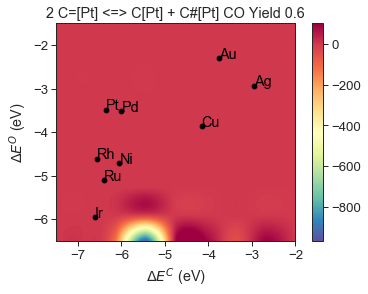

Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Selectivity 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Selectivity 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Selectivity 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Selectivity 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Selectivity 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Selectivity 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Selectivity 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Selectivity 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Selectivity 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Selectivity 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Selectivity 0.6
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.77451795204e-06, -1.71042629784e-06, 1.42852680858e-05, 0.00198147787705, 0.18205576901299997, 46.9613259726, -0.04874582246280001, 5.16544386046e-07, -0.00192151426659, 4.

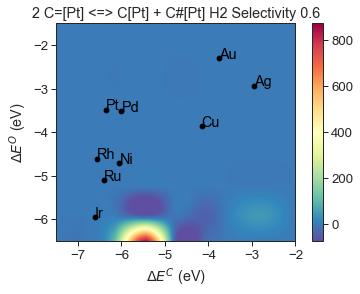

Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Yield 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Yield 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Yield 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Yield 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Yield 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Yield 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Yield 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Yield 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Yield 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Yield 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Yield 0.6
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.7856347837599999e-06, 1.7410559378700001e-06, -7.55975038086e-06, -0.0017045883760199998, -0.0007003882849860001, -4.05114734365e-09, 0.0487458223154, 3.4910197872600004e-07, 0.00192143243049, 7.256966574070001e-09, -5.68093069892e-05, -

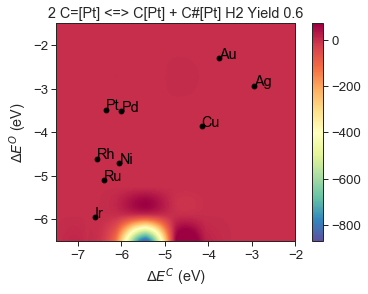

Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CH4 Conversion 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CH4 Conversion 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CH4 Conversion 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CH4 Conversion 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CH4 Conversion 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CH4 Conversion 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CH4 Conversion 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CH4 Conversion 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CH4 Conversion 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CH4 Conversion 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CH4 Conversion 0.6
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.11168371456e-08, -3.06296457435e-08, -6.72551673806e-06, -0.00027688401461400003, -0.181025812793, -31.954887217899998, 1.4748242281799997e-10, -8.65646374794e-07, 8.183768

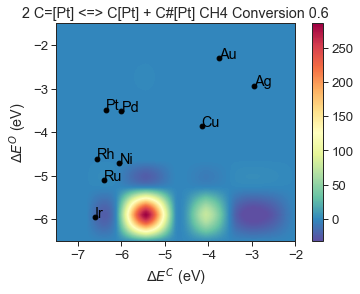

Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO2+H2O Selectivity 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO2+H2O Selectivity 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO2+H2O Selectivity 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO2+H2O Selectivity 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO2+H2O Selectivity 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO2+H2O Selectivity 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO2+H2O Selectivity 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO2+H2O Selectivity 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO2+H2O Selectivity 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO2+H2O Selectivity 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO2+H2O Selectivity 0.6
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -2.05008447693e-09, 3.08066036551e-08, 7.16739009137e-06, 0.000287632724906, 0.181350958516, 46.961327230900004, -0.357

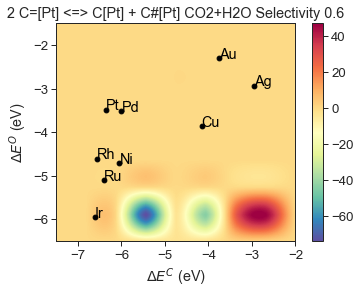

Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO2+H2O Yield 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO2+H2O Yield 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO2+H2O Yield 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO2+H2O Yield 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO2+H2O Yield 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO2+H2O Yield 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO2+H2O Yield 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO2+H2O Yield 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO2+H2O Yield 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO2+H2O Yield 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO2+H2O Yield 0.6
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.06674607902e-09, 1.7696922472900001e-10, 4.4187286230200005e-07, 1.07479138863e-05, -3.1463231773e-06, 8.602847167040001e-07, -0.357295812133, -1.1916755820299999e-07, 7.72413129574e-

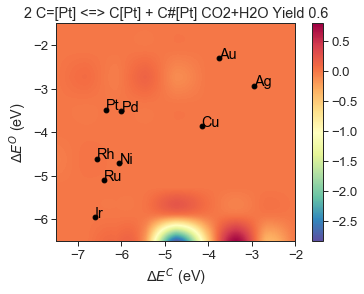

Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] Exit Temperature 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] Exit Temperature 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] Exit Temperature 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] Exit Temperature 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] Exit Temperature 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] Exit Temperature 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] Exit Temperature 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] Exit Temperature 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] Exit Temperature 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] Exit Temperature 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] Exit Temperature 0.6
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.44895651099e-10, -4.3200486190199995e-12, 1.4292058611099999e-12, 1.12062739996e-12, 5.79802872379e-12, -3.21571340984e-12, 1.5753747512900002e-12, -1

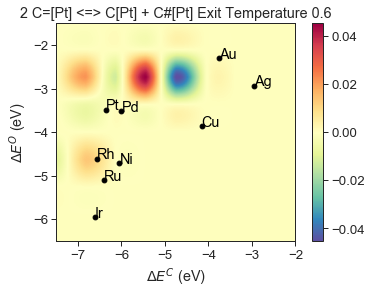

Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] Maximum Temperature 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] Maximum Temperature 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] Maximum Temperature 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] Maximum Temperature 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] Maximum Temperature 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] Maximum Temperature 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] Maximum Temperature 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] Maximum Temperature 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] Maximum Temperature 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] Maximum Temperature 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] Maximum Temperature 0.6
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.44895651099e-10, -4.3200486190199995e-12, 1.4292058611099999e-12, 1.80274842602e-12, 3.1020265721099997e-12, -1.20183

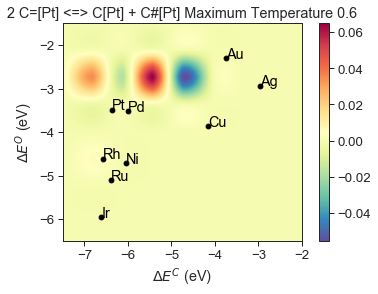

Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] Dist to Max Temperature 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] Dist to Max Temperature 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] Dist to Max Temperature 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] Dist to Max Temperature 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] Dist to Max Temperature 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] Dist to Max Temperature 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] Dist to Max Temperature 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] Dist to Max Temperature 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] Dist to Max Temperature 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] Dist to Max Temperature 0.6
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] Dist to Max Temperature 0.6
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 59.0503055947, 27.420948616599997, 63.536463536499994, 1011.

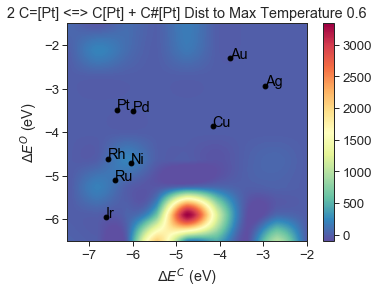

Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Selectivity 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Selectivity 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Selectivity 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Selectivity 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Selectivity 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Selectivity 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Selectivity 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Selectivity 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Selectivity 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Selectivity 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Selectivity 0.7
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -5.945536803189999e-07, -1.08112319551e-07, -5.03522618855e-06, 0.00044048554524599994, -0.025357815519599997, 13.519818793399999,

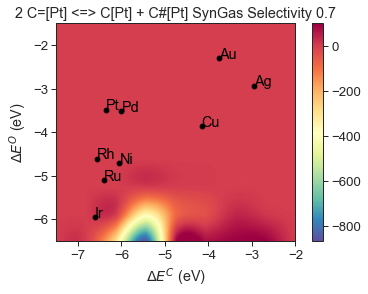

Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Yield 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Yield 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Yield 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Yield 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Yield 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Yield 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Yield 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Yield 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Yield 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Yield 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] SynGas Yield 0.7
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -7.81778487755e-07, -1.39045120187e-09, -7.36660997509e-07, -0.000491680455809, 4.12321230839e-05, 6.09781027137e-06, -4.70205113291e-08, 1.5697260369700001e-07, -2.99263387623e-06, 1.45839200515e

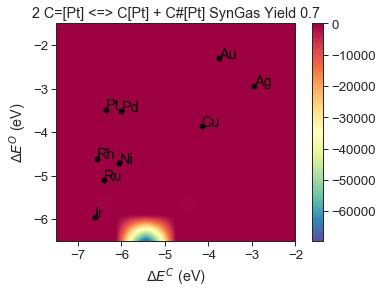

Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Selectivity 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Selectivity 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Selectivity 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Selectivity 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Selectivity 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Selectivity 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Selectivity 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Selectivity 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Selectivity 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Selectivity 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Selectivity 0.7
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.67183240162e-07, 1.07078676618e-07, 5.03520123472e-06, -0.000872415693909, 0.025392885206200002, -13.5198466235, -98.6121896123, 2.67626065017e-07, 2.3459570941100002e-07, 

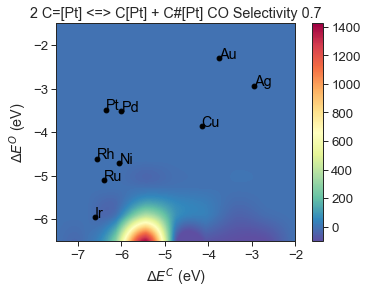

Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Yield 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Yield 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Yield 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Yield 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Yield 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Yield 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Yield 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Yield 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Yield 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Yield 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO Yield 0.7
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -3.5440804084e-07, -3.56789858805e-10, -7.36636047457e-07, -5.974628082e-05, 6.17134161989e-06, 3.82787675175e-05, -0.00227751649011, -3.1785890682800003e-07, -2.05773383457e-07, 1.33721377048e-07, -7.414072514789999e-10, -2.03042368622e-06

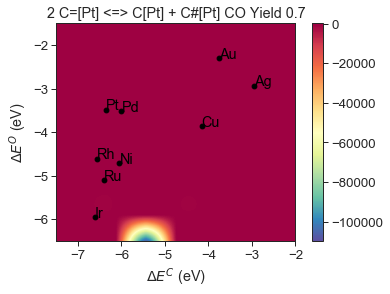

Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Selectivity 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Selectivity 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Selectivity 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Selectivity 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Selectivity 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Selectivity 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Selectivity 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Selectivity 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Selectivity 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Selectivity 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Selectivity 0.7
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.95554817314e-07, 1.13410589959e-06, 5.2462873691e-06, -0.00013172353519099998, 0.0253578084043, -13.519818793399999, -98.61222121860001, -2.07205450731e-07, 7.80328657842e-

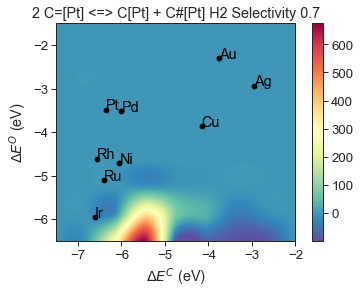

Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Yield 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Yield 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Yield 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Yield 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Yield 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Yield 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Yield 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Yield 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Yield 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Yield 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] H2 Yield 0.7
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -7.827796095069999e-07, -1.0273840402799999e-06, -9.47722179999e-07, -0.0008004453440569999, 4.12392366614e-05, 6.09780765636e-06, -4.70204335822e-08, 1.5697260369700001e-07, -7.77446424415e-06, 1.55283355645e-06, -5.00595170492e-06, 3.6538

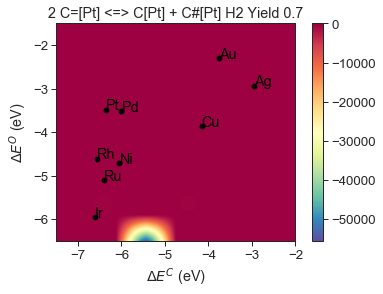

Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CH4 Conversion 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CH4 Conversion 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CH4 Conversion 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CH4 Conversion 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CH4 Conversion 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CH4 Conversion 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CH4 Conversion 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CH4 Conversion 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CH4 Conversion 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CH4 Conversion 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CH4 Conversion 0.7
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.87224790827e-07, -1.06721869936e-07, -4.29856497608e-06, 0.000932170107132, -0.0253926086318, 15.6334231808, 7105.759403800001, 5.02328415953e-08, -2.8822315468799996e-08, 

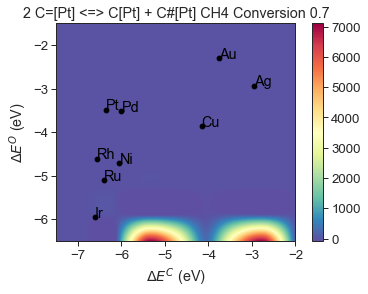

Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO2+H2O Selectivity 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO2+H2O Selectivity 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO2+H2O Selectivity 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO2+H2O Selectivity 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO2+H2O Selectivity 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO2+H2O Selectivity 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO2+H2O Selectivity 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO2+H2O Selectivity 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO2+H2O Selectivity 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO2+H2O Selectivity 0.7
Adding placeholder for 2 C=[Pt] <=> C[Pt] + C#[Pt] CO2+H2O Selectivity 0.7
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0689806108e-09, 1.07098533131e-07, 4.9571362118e-06, -0.0009005323942559999, 0.0253938037811, -13.5198487224, -98.612

In [ ]:
reactions = set()
for f in range(len(allrxndata)):
    for r in range(len(allrxndata[0][0])):
        reactions.add(allrxndata[f][0][r][1])
reactions = list(reactions)

for rxn in rxns_unique:  # for a certain reaction
    for r in range(len(allrxndata[0])):  # for a single ratio
        for s in xrange(2,14):  # for a sensitivity type
            sensitivities = []
            title = rxn + ' '+ sens_types[s-2] + ' ' + str(ratios[r])
            got_value = False
            
            for f in range(len(array)):  # for lsr binding energies
                for p in range(len(allrxndata[f][r])):  # matching the reaction
                    if allrxndata[f][r][p][1] == np.str(rxn):
                        sensitivities.append(allrxndata[f][r][p][s])
                        got_value = True
                if got_value is False:  # put a placeholder in
                    print('Adding placeholder for ' + title)
                    sensitivities.append(0.)
            
#             MAX = 5  # this is arbitrary... maybe write in something smarter?

#             lavaPlot(sensitivities, title)
            print sensitivities
            # cull out the boring plots
            if sum(abs(np.array(sensitivities))>1e-5) < 3:
                print "skipping {} because it's boring".format(title)
                continue
                
#             lavaPlot(sensitivities, title, axis=[-1 * MAX, MAX])
            lavaPlot(sensitivities, title)

In [481]:
test = allrxndata[0][0][1][1]
print type(test)
print test
t = rxns_unique[43]
print type(t)
print t
print type(np.str(test))
print type(np.str(t))

if test == np.str(t):
    print 'ok'

<type 'str'>
[O][O] + 2 [Pt] <=> 2 O=[Pt]
<type 'numpy.string_'>
[O][O] + 2 [Pt] <=> 2 O=[Pt]
<type 'str'>
<type 'str'>
ok


In [9]:
# Plot the number of surface reactions
# num_surf_reactions

# reaction_counts_grid = np.log10(np.reshape(num_surf_reactions, (grid_size,grid_size)))
# plt.imshow(reaction_counts_grid.T, interpolation='none', origin='lower', extent=extent2, aspect='equal')
# plt.xlim(carbon_range2)
# plt.ylim(oxygen_range2)
# plt.xlabel('$\Delta E^C$ (eV)')
# plt.ylabel('$\Delta E^O$ (eV)')
# for e,n in zip(experiments,num_surf_reactions):
#     plt.text(e[0],e[1],n,color='w',ha='center', va='center')
# plt.colorbar()

In [10]:
# A linear one, just to check it looks the same
# reaction_counts_grid = np.reshape(num_surf_reactions, (grid_size,grid_size))
# ax = sns.heatmap(reaction_counts_grid.T[::-1,:], annot=True, fmt='d', square=True)